In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgb
from matplotlib import rcParams

#Latex is needed to create plot titles
rcParams['text.usetex'] = True #set this to False if Latex distribution is not installed
rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amsfonts}\usepackage{systeme}"
%config InlineBackend.figure_format = 'retina'

In [2]:
def create_colormap(hex_color1, hex_color2, reverse=False):
    """
    Create a linearly interpolated colormap from two hex colors.

    -hex_color1: String, the first hex color (e.g., "#FF0000" for red)
    -hex_color2: String, the second hex color (e.g., "#0000FF" for blue)
    -reverse: Boolean, invert colors.
    
    Return: LinearSegmentedColormap
    """
    color1 = to_rgb(hex_color1)
    color2 = to_rgb(hex_color2)
    if reverse:
        colors = [color2, color1]
    else:
        colors = [color1, color2]
    cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)

    return cmap

In [3]:
# a custom colormap
c_labels = "#000000"
yellow_map = create_colormap("#000000", "#ffe100", True)

In [4]:
@njit
def meshgrid(x, y):
    """
    This function replace np.meshgrid that is not supported by numba
    """
    xx = np.empty(shape=(x.size, y.size), dtype=x.dtype)
    yy = np.empty(shape=(x.size, y.size), dtype=y.dtype)
    for j in range(y.size):
        for k in range(x.size):
            xx[j,k] = k  # change to x[k] if indexing xy
            yy[j,k] = j  # change to y[j] if indexing xy
    return xx, yy

@njit
def calc_orbit(n_points, a, b, n_iter):
    """
    This function calculate orbits in a vectorized fashion.

    -n_points: lattice of initial conditions, n_points x n_points in [-1,1]x[-1,1]
    -a: first parameter of the dynamical system
    -b: second parameter of the dynamical system
    -n_iter: number of iterations

    Return: two ndarrays: x and y coordinates of every point of every orbit.
    """
    area = [[-1,1],[-1,1]]
    x = np.linspace(area[0][0],area[0][1],n_points)
    y = np.linspace(area[1][0],area[1][1],n_points)
    xx,yy = meshgrid(x,y)
    l_cx,l_cy=np.zeros(n_iter*n_points**2),np.zeros(n_iter*n_points**2)
    for i in range(n_iter):
        xx_new = np.sin(xx**2-yy**2 + a)
        yy_new = np.cos(2*xx*yy + b)
        xx = xx_new
        yy = yy_new
        l_cx[i*n_points**2:(i+1)*n_points**2] = xx.flatten()
        l_cy[i*n_points**2:(i+1)*n_points**2] = yy.flatten()
    return l_cx, l_cy

In [5]:
n_points = 500
n_iter = 200
a, b = 5.46, 4.55
l_cx, l_cy = calc_orbit(n_points, a, b, n_iter)

In [6]:
area = [[-1,1],[-1,1]]
h,_,_ = np.histogram2d(l_cx,l_cy,bins=3000,range=area)

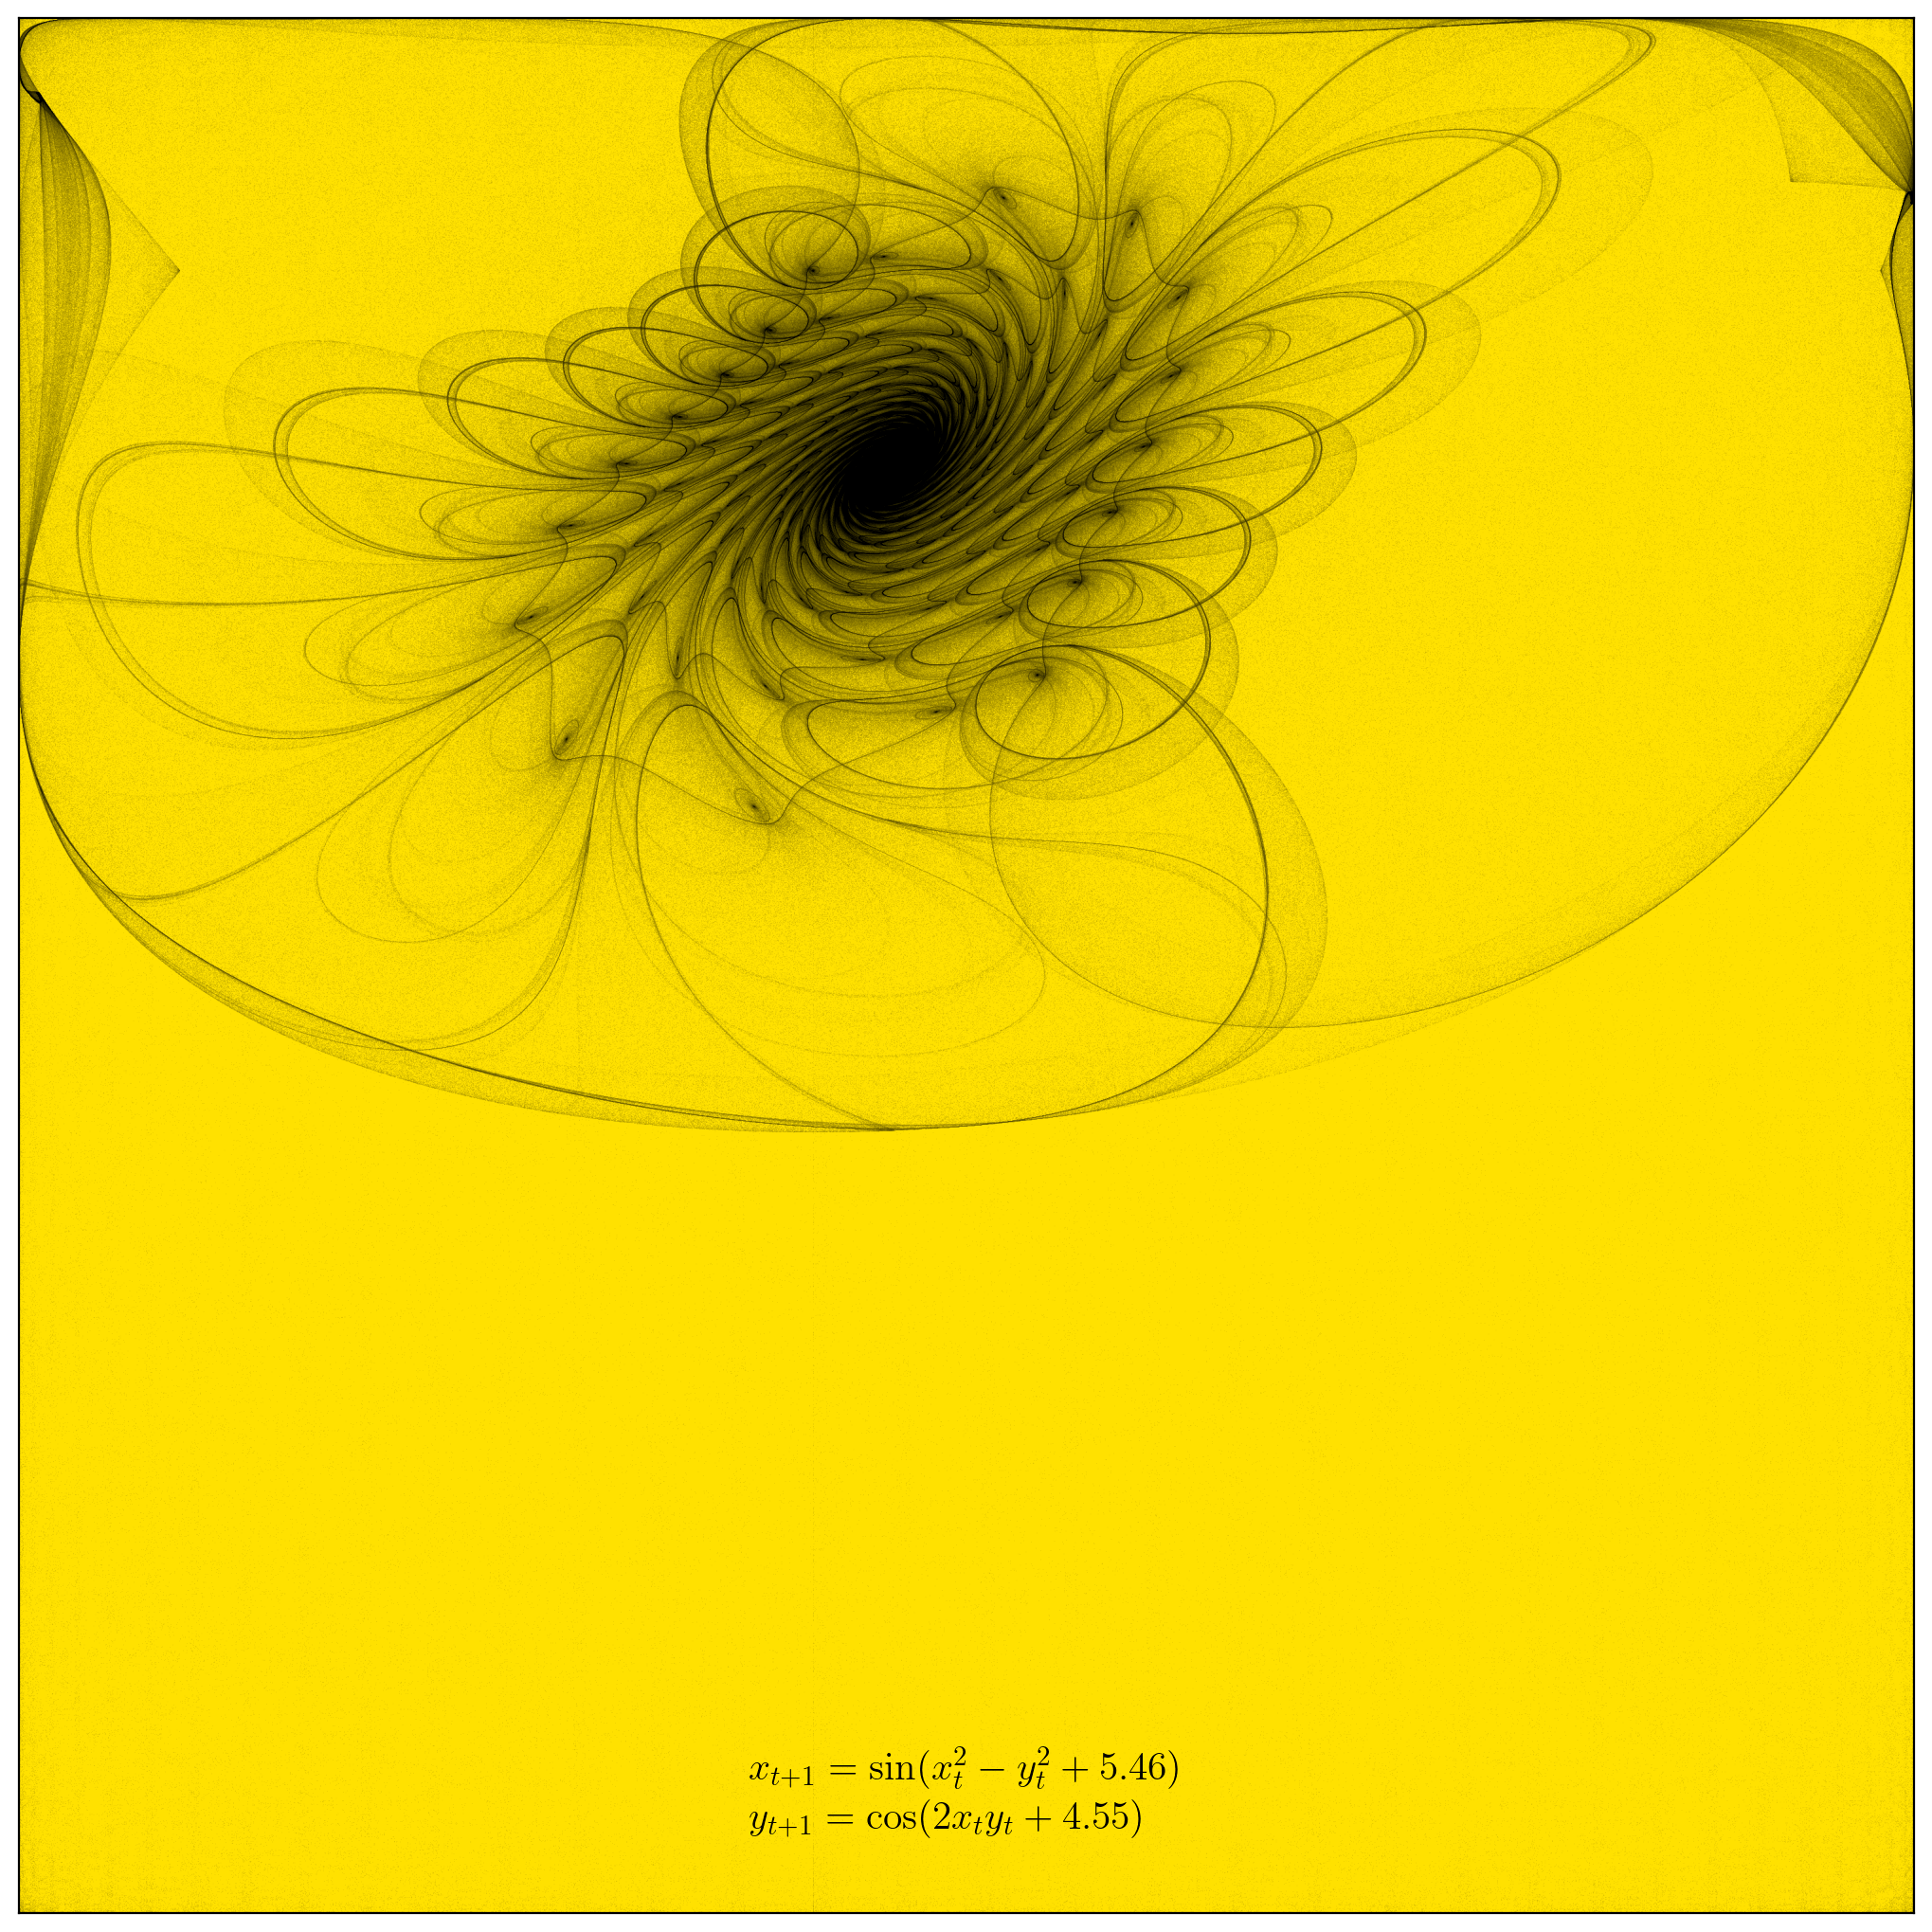

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.imshow(np.log(h+1),vmin=0,vmax=5,cmap=yellow_map)
plt.xticks([]), plt.yticks([])
ax.set_title(r'$\begin{array}{lr} x_{t+1} = \sin(x_t^2-y_t^2 + %s) \\ y_{t+1} = \cos(2x_t y_t + %s) \end{array}$'%(a,b), 
             y=0.05, fontsize=15, color=c_labels )
plt.show()